In [2]:
import random
import string
import time
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
import matplotlib.cm as cm
from matplotlib.colors import Normalize
import numpy.matlib as npmatlib
%matplotlib inline
import pickle
from IPython.display import clear_output

import gc

import dataloader
import util
import autoencoder

from scipy.optimize import minimize
from keras import backend as K
import tensorflow as tf

#load data
dataset = dataloader.DataLoader(verbose=True)
x_train, x_test, y_train, y_test, y_reg_train, y_reg_test = dataset.load_data()

#vectorize the images and data
x_train = np.reshape(x_train, [x_train.shape[0], x_train.shape[1]*x_train.shape[2]]).T
x_test = np.reshape(x_test, [x_test.shape[0], x_test.shape[1]*x_test.shape[2]]).T
y_reg_train = y_reg_train.T
y_reg_test = y_reg_test.T

#forward model (i.e. simualator)
G = np.load('G.npy')

#parameters
sz = 28
ref = 3
num_samples = 100

#dobs
d_obs = np.multiply(y_reg_test[:, ref:ref+1], np.expand_dims(dataset.maxs, axis=-1))
m_ref = x_test[:, ref:ref+1]

#color by label
my_cmap = cm.get_cmap('jet')
my_norm = Normalize(vmin=0, vmax=9)
cs = my_cmap(my_norm(y_test))

print(x_train.shape)
print(x_test.shape)
print(y_reg_train.shape)
print(y_reg_test.shape)
print(G.shape)

print(d_obs.shape)
print(m_ref.shape)

Loaded training data x (60000, 28, 28, 1) and y (60000, 128) and y_labels (60000,)
Loaded testing data x (10000, 28, 28, 1) and y (10000, 128) and y_labels (10000,)
(784, 60000)
(784, 10000)
(128, 60000)
(128, 10000)
(784, 128)
(128, 1)
(784, 1)


In [17]:
#train the autoencoder
z_dim = 3

AE = autoencoder.Autoencoder(x_sz=x_train.shape[0], z_dim=z_dim)
AE.train_autoencoder2D(x_train.T, load = True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 512)               401920    
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 128)               32896     
_________________________________________________________________
leaky_re_lu_10 (LeakyReLU)   (None, 128)               0         
__________

In [4]:
#reconstructions with the trained model
x_train_hat = AE.m2m.predict(x_train.T).T
x_test_hat = AE.m2m.predict(x_test.T).T

print(x_train_hat.shape)
print(x_test_hat.shape)

(784, 60000)
(784, 10000)


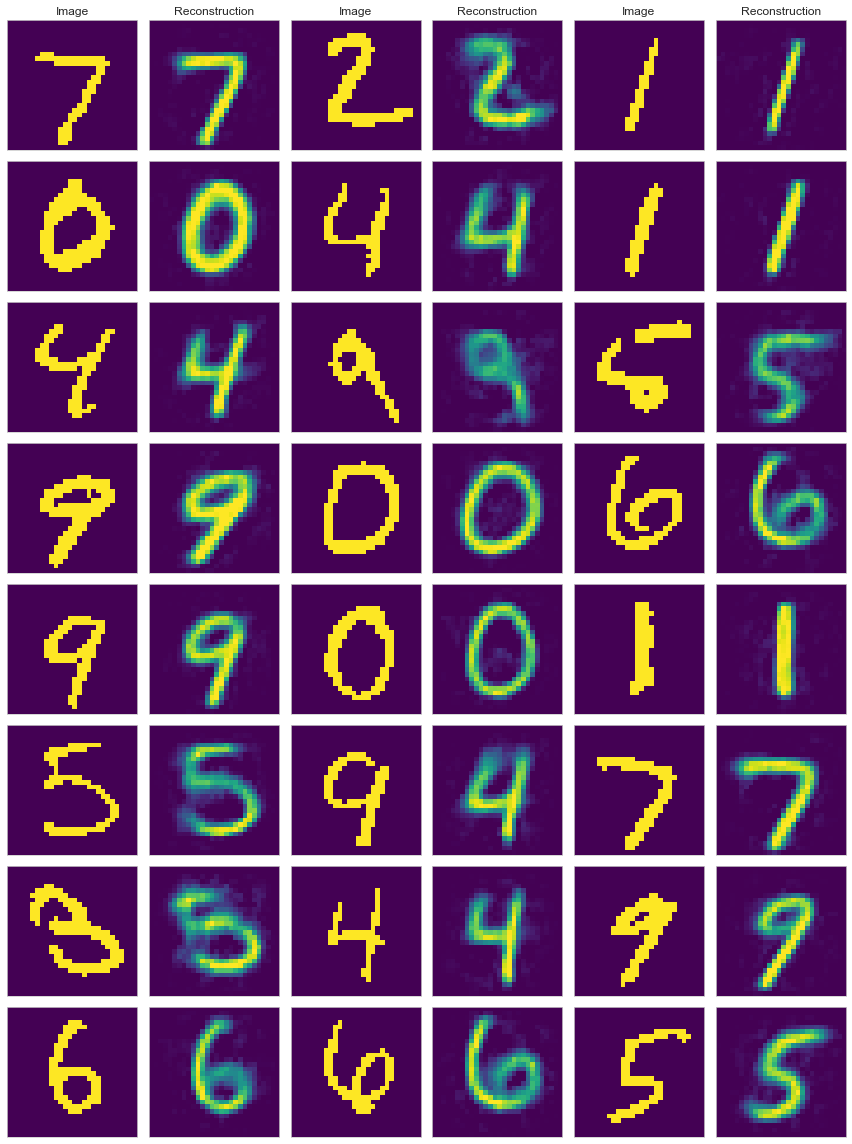

In [5]:
#plot some test images with predicted vs true labels
num_rows = 8
num_cols = 3
num_images = num_rows*num_cols

plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
    
    plt.subplot(num_rows, 2*num_cols, 2*i+1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(np.reshape(x_test[:,i], [sz, sz]), vmin=0, vmax=1, cmap="viridis")
    if i < 3:
        plt.title('Image')
    
    plt.subplot(num_rows, 2*num_cols, 2*i+2)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(np.reshape(x_test_hat[:,i], [sz, sz]), vmin=0, vmax=1, cmap="viridis")
    if i < 3:
        plt.title('Reconstruction')
    
plt.tight_layout()
plt.show()

(10000, 3)


Text(0.5, 1.0, 'Feature space')

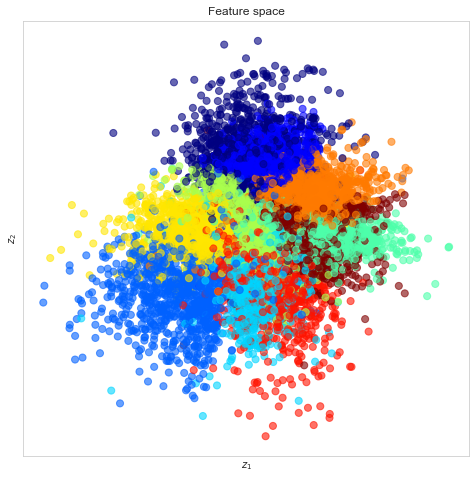

In [6]:
#plot the first few latent variables (out of 64!) and color code with label

z_test = AE.m2zm.predict(x_test.T)
print(z_test.shape)

import matplotlib.cm as cm
from matplotlib.colors import Normalize

fig, ax = plt.subplots(1,1, figsize = (8, 8))

my_cmap = cm.get_cmap('jet')
my_norm = Normalize(vmin=0, vmax=9)
cs = my_cmap(my_norm(y_test))

ax.scatter(z_test[:, 0], z_test[:, 1], s=50, c=cs, alpha=0.6)
ax.set_xticks([])
ax.set_yticks([])
plt.xlabel('$z_1$')
plt.ylabel('$z_2$')
plt.title('Feature space')

(10, 1, 3)
(10, 784)


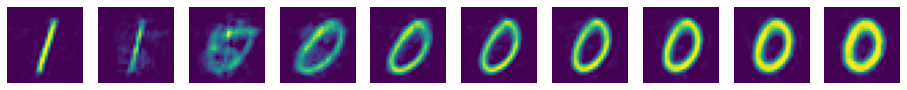

In [7]:
#sample two images from the testing set and uniformly sample the latent spaces (all zs)
sample_1 = x_test[:, 2:3].T
sample_2 = x_test[:, 3:4].T
sample_1_z = AE.m2zm.predict(sample_1)
sample_2_z = AE.m2zm.predict(sample_2)

num_samples = 10
samples_z = np.linspace(sample_1_z, sample_2_z, num_samples, endpoint=True)

#display the reconstructed images from the samples
samples_image = AE.zm2m.predict(np.squeeze(samples_z))

print(samples_z.shape)
print(samples_image.shape)

#display sampled images
plt.figure(figsize=[16, 4])
for i in range(num_samples):
    plt.subplot(1, 10, i+1)
    plt.imshow(np.reshape(samples_image[i,:], [sz, sz]), vmin=0, vmax=1, cmap="viridis")
    plt.axis('off')

In [8]:
#reduced representation of reference
zm_ref = AE.m2zm.predict(m_ref.T)

#initial guess (sensitive!)
zm0 = np.squeeze(np.random.normal(size=zm_ref.T.shape)*0.0)
print(zm0.shape)

(3,)


In [9]:
#load the arrays
with open("x.txt", "rb") as fp:
    x = pickle.load(fp)
    
with open("losses.txt", "rb") as fp:
    losses = pickle.load(fp)
    
with open("zms.txt", "rb") as fp:
    zms = pickle.load(fp)
    
i = len(x)
logs = []

zm0 = zms[-1]
print(zm0.shape)

(3,)


In [ ]:
i = 0
logs = []

x = []
losses = []
zms = []

In [10]:
#callback to monitor optimization process
def monitor(xk):
    
    global i, x, losses, logs, zms

    fig = plt.figure(figsize=[15, 5])
    logs.append(logs)
    x.append(i)
    losses.append(func(xk))
    zms.append(xk)
    i += 1
    #clear_output(wait=True)
    
    plt.subplot(1, 3, 1)
    plt.plot(x, losses, label="loss", c = 'green')
    plt.ylabel("Loss function")
    plt.xlabel("Iter.")
    plt.title("Loss vs iter.")
    
    plt.subplot(1, 3, 2)
    plt.scatter(zm_ref.flatten(), zm_ref.flatten(), s=10, color='red', alpha=0.5, label="$zm_{ref}$", zorder=20)
    plt.scatter(zm_ref.flatten(), xk.flatten(), s=30, color=cs[y_test[ref]], alpha=1.0)
    plt.xlabel("$zm_{ref}$")
    plt.ylabel("$zm_{sol}$")
    plt.legend()
    plt.title('zm - Ref vs Solution')

    plt.subplot(1, 3, 3)
    m_sol = np.squeeze(AE.zm2m.predict(np.expand_dims(xk, axis=-1).T))
    plt.imshow(np.reshape(m_sol, [sz, sz]), cmap="viridis", aspect='equal', vmin=0, vmax=1)
    plt.xticks([]), plt.yticks([])
    plt.title("Inv. model")

    plt.show()
    
    if i % 100 == 0:
        fig.savefig('readme/grad_ae_dim.png')

In [11]:
#equation to solve
def func(zm):
    m = AE.zm2m.predict(np.expand_dims(zm, axis=-1).T).T
    return np.sqrt(np.mean(np.abs(G.T@m - d_obs)))

#sess = K.get_session()

#jacobian for decoder
def dmdzm(zm):
    
    tic = time.time()
    
    sess = tf.InteractiveSession()
    sess.run(tf.global_variables_initializer())
    
    jac_matrix = []
    for idx in range(sz*sz):
        grad_f = K.gradients(AE.zm2m.output[:, idx], AE.zm2m.input)
        grads = sess.run(grad_f, feed_dict={AE.zm2m.input: zm.reshape((1, zm.size))})        
        jac_matrix.append(grads[0][0,:])
        
        if idx % 100 == 0:
            print(idx)
        
    tac = time.time()
    print('Gradient comp. %.3f s.' % (tac-tic)) 
    
    gc.collect()
    sess.close()
        
    return np.array(jac_matrix)

#gradient of the equation
def dldzm(zm):
    monitor(zm)
    m = AE.zm2m.predict(np.expand_dims(zm, axis=-1).T).T
    dldm = (G@(G.T@m - d_obs)).T
    return np.squeeze(dldm@dmdzm(zm))

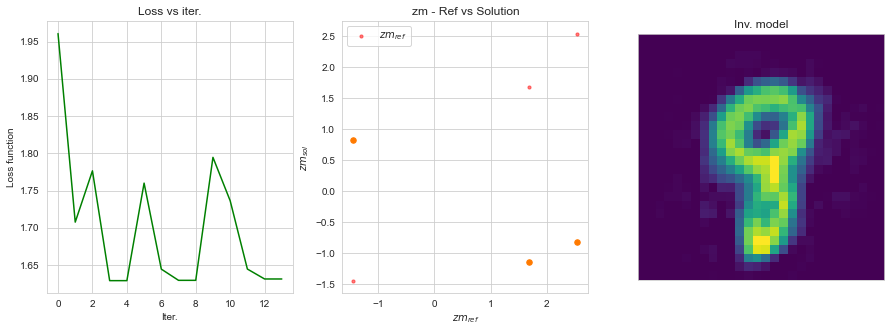

0
100
200
300
400
500
600
700
Gradient comp. 245.130 s.


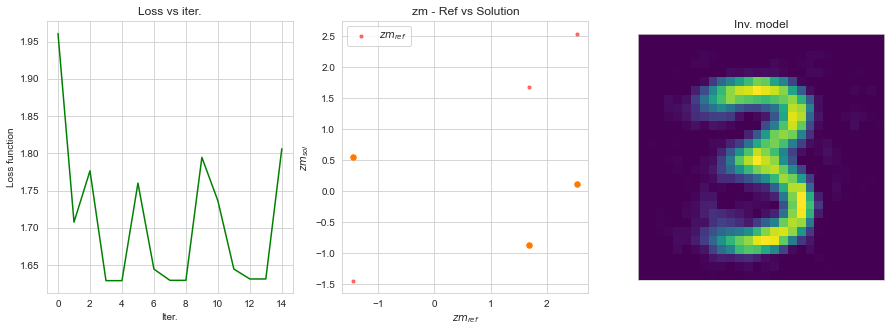

0
100
200
300
400


KeyboardInterrupt: 

In [12]:
#minimize the objective function
#res = minimize(func, zm0, method='BFGS', jac=dldzm, options={'disp': True, 'maxiter': 3})
res = minimize(func, zm0, method='BFGS', callback=monitor, jac=dldzm, options={'gtol':1e-6, 'disp': True, 'maxiter': 3000})

In [13]:
#save the arrays
with open("x.txt", "wb") as fp:
    pickle.dump(x, fp)
    
with open("losses.txt", "wb") as fp:
    pickle.dump(losses, fp)
    
with open("zms.txt", "wb") as fp:
    pickle.dump(zms, fp)

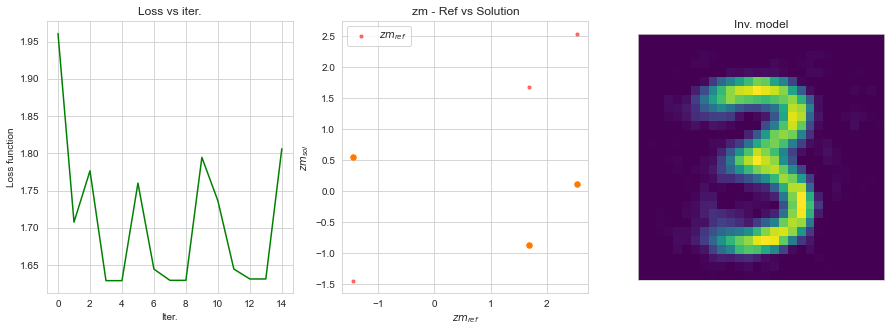

In [18]:
#plot loss and solution
fig = plt.figure(figsize=[15, 5])

plt.subplot(1, 3, 1)
plt.plot(x, losses, label="loss", c = 'green')
plt.ylabel("Loss function")
plt.xlabel("Iter.")
plt.title("Loss vs iter.")

plt.subplot(1, 3, 2)
plt.scatter(zm_ref.flatten(), zm_ref.flatten(), s=10, color='red', alpha=0.5, label="$zm_{ref}$", zorder=20)
plt.scatter(zm_ref.flatten(), zms[-1].flatten(), s=30, color=cs[y_test[ref]], alpha=1.0)
plt.xlabel("$zm_{ref}$")
plt.ylabel("$zm_{sol}$")
plt.legend()
plt.title('zm - Ref vs Solution')

plt.subplot(1, 3, 3)
m_sol = np.squeeze(AE.zm2m.predict(np.expand_dims(zms[-1], axis=-1).T))
plt.imshow(np.reshape(m_sol, [sz, sz]), cmap="viridis", aspect='equal', vmin=0, vmax=1)
plt.xticks([]), plt.yticks([])
plt.title("Inv. model")

plt.show()

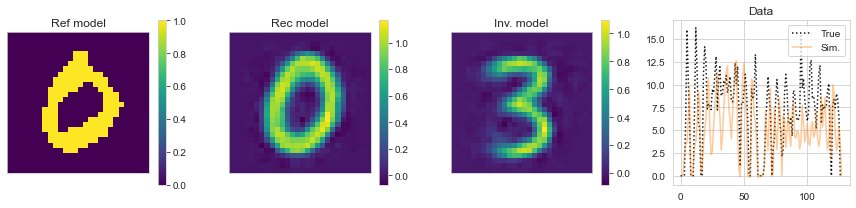

In [19]:
#forward simulation on the inverted model
y_sim = (m_sol@G).T

#compare model and data (i.e. reference case vs solution)
f = plt.figure(figsize=(12, 3))
plt.subplot(1, 4, 1)
plt.imshow(np.reshape(m_ref, [sz, sz]), cmap="viridis", vmin=0, vmax=1, aspect='equal')
plt.xticks([]), plt.yticks([])
plt.colorbar()
plt.title("Ref model")

plt.subplot(1, 4, 2)
plt.imshow(np.reshape(AE.m2m.predict(m_ref.T), [sz, sz]), cmap="viridis", aspect='equal')
plt.xticks([]), plt.yticks([])
plt.colorbar()
plt.title("Rec model")

plt.subplot(1, 4, 3)
plt.imshow(np.reshape(m_sol, [sz, sz]), cmap="viridis", aspect='equal')
plt.xticks([]), plt.yticks([])
plt.colorbar()
plt.title("Inv. model")

plt.subplot(1, 4, 4)
plt.plot(d_obs, ls=':', c='k', label='True', alpha=0.9)
plt.plot(y_sim, c=cs[y_test[ref]], label='Sim.', alpha=0.4)
#plt.ylim([0, 1])
plt.title("Data")
plt.legend()

plt.tight_layout()
f.savefig('readme/grad_ae_dim_comp.png')